In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os
import keras
from keras_unet.models import custom_unet

Populating the interactive namespace from numpy and matplotlib


2023-03-31 22:56:06.481171: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [3]:
images = np.load(images_file)
labels = np.load(labels_file)

In [4]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [5]:
p = np.random.permutation(len(images))

In [6]:
images = images[p]
labels = labels[p]

In [7]:
labels = labels.astype(np.float64)

In [8]:
images = images.astype(np.float64)

for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [9]:
images.shape, labels.shape

((766, 512, 512, 1), (766, 512, 512, 1))

In [10]:
import json

In [11]:
with open("image_data_v3.json", "r") as fp:
    image_data = json.load(fp)
with open("label_data_v3.json", "r") as fp:
    label_data = json.load(fp)

In [12]:
X_train = images[0:image_data['82']]
y_train = labels[0:label_data['82']]
X_val = images[image_data['82']:]
y_val = labels[label_data['82']:]

In [13]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 512, 512, 1) (2, 512, 512, 1)


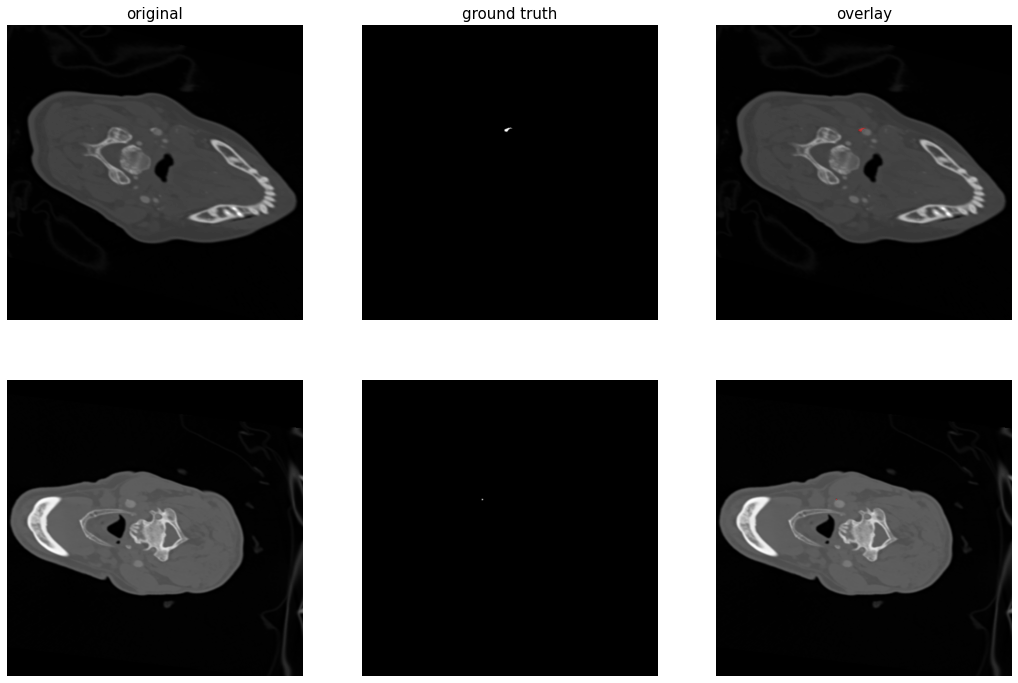

In [14]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)


In [15]:
model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=32,
    dropout=0.2,
    num_layers=2,
    output_activation='sigmoid')

2023-03-31 22:56:23.315906: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-31 22:56:23.485119: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-31 22:56:23.487973: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-31 22:56:23.487991: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-03-31 22:56:23.490891: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-31 

In [16]:
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from tensorflow.keras.optimizers import Adam

In [17]:
model.compile(optimizer = Adam(learning_rate=0.001),
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

In [18]:
history = model.fit(#X_train, 
                    #y_train, 
                    train_gen,
                    steps_per_epoch=20,
                    epochs=200,
                    validation_data=(X_val, y_val))

2023-03-31 22:56:25.250119: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-31 22:56:25.269178: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200


2023-03-31 22:56:26.086013: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-03-31 22:56:26.699476: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-03-31 22:56:27.348488: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-03-31 22:56:27.348513: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-03-31 22:56:27.348580: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-03-31 22:56:27.389108: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-31 22:56:28.093613: I tensorflow/stream_exec

20/20 [==============================] - 10s 263ms/step - loss: 0.1703 - iou: 3.5361e-04 - iou_thresholded: 0.0084 - val_loss: 0.0197 - val_iou: 6.2366e-05 - val_iou_thresholded: 3.9249e-04
Epoch 2/200
20/20 [==============================] - 2s 85ms/step - loss: 0.0171 - iou: 0.0016 - iou_thresholded: 0.0145 - val_loss: 0.0072 - val_iou: 1.8439e-04 - val_iou_thresholded: 3.9249e-04
Epoch 3/200
20/20 [==============================] - 2s 86ms/step - loss: 0.0069 - iou: 0.0018 - iou_thresholded: 0.0143 - val_loss: 0.0047 - val_iou: 2.8252e-04 - val_iou_thresholded: 3.9249e-04
Epoch 4/200
20/20 [==============================] - 2s 86ms/step - loss: 0.0062 - iou: 0.0023 - iou_thresholded: 0.0076 - val_loss: 0.0062 - val_iou: 6.6404e-04 - val_iou_thresholded: 3.9249e-04
Epoch 5/200
20/20 [==============================] - 2s 87ms/step - loss: 0.0061 - iou: 0.0023 - iou_thresholded: 0.0057 - val_loss: 0.0044 - val_iou: 3.1885e-04 - val_iou_thresholded: 3.9249e-04
Epoch 6/200
20/20 [=======

20/20 [==============================] - 2s 86ms/step - loss: 0.0031 - iou: 0.0345 - iou_thresholded: 0.0057 - val_loss: 0.0020 - val_iou: 0.0549 - val_iou_thresholded: 3.9249e-04
Epoch 44/200
20/20 [==============================] - 2s 86ms/step - loss: 0.0031 - iou: 0.0407 - iou_thresholded: 0.0075 - val_loss: 0.0020 - val_iou: 0.0485 - val_iou_thresholded: 3.9249e-04
Epoch 45/200
20/20 [==============================] - 2s 86ms/step - loss: 0.0038 - iou: 0.0266 - iou_thresholded: 0.0054 - val_loss: 0.0024 - val_iou: 0.0288 - val_iou_thresholded: 3.9249e-04
Epoch 46/200
20/20 [==============================] - 2s 99ms/step - loss: 0.0028 - iou: 0.0322 - iou_thresholded: 0.0073 - val_loss: 0.0030 - val_iou: 0.0149 - val_iou_thresholded: 3.9249e-04
Epoch 47/200
20/20 [==============================] - 2s 87ms/step - loss: 0.0038 - iou: 0.0197 - iou_thresholded: 0.0074 - val_loss: 0.0027 - val_iou: 0.0397 - val_iou_thresholded: 3.9249e-04
Epoch 48/200
20/20 [============================

20/20 [==============================] - 2s 86ms/step - loss: 0.0019 - iou: 0.0628 - iou_thresholded: 0.0830 - val_loss: 0.0016 - val_iou: 0.0967 - val_iou_thresholded: 0.0711
Epoch 87/200
20/20 [==============================] - 2s 86ms/step - loss: 0.0023 - iou: 0.0873 - iou_thresholded: 0.1022 - val_loss: 0.0016 - val_iou: 0.1513 - val_iou_thresholded: 0.3086
Epoch 88/200
20/20 [==============================] - 2s 87ms/step - loss: 0.0028 - iou: 0.0912 - iou_thresholded: 0.1374 - val_loss: 0.0026 - val_iou: 0.0809 - val_iou_thresholded: 0.2227
Epoch 89/200
20/20 [==============================] - 2s 86ms/step - loss: 0.0028 - iou: 0.0683 - iou_thresholded: 0.0874 - val_loss: 0.0017 - val_iou: 0.0679 - val_iou_thresholded: 0.0083
Epoch 90/200
20/20 [==============================] - 2s 86ms/step - loss: 0.0035 - iou: 0.0685 - iou_thresholded: 0.0599 - val_loss: 0.0018 - val_iou: 0.1008 - val_iou_thresholded: 0.1455
Epoch 91/200
20/20 [==============================] - 2s 86ms/step -

20/20 [==============================] - 2s 88ms/step - loss: 0.0016 - iou: 0.1784 - iou_thresholded: 0.2738 - val_loss: 0.0015 - val_iou: 0.2182 - val_iou_thresholded: 0.3810
Epoch 130/200
20/20 [==============================] - 2s 85ms/step - loss: 0.0039 - iou: 0.0996 - iou_thresholded: 0.1787 - val_loss: 0.0018 - val_iou: 0.1087 - val_iou_thresholded: 0.2381
Epoch 131/200
20/20 [==============================] - 2s 86ms/step - loss: 0.0023 - iou: 0.0663 - iou_thresholded: 0.1128 - val_loss: 0.0018 - val_iou: 0.1379 - val_iou_thresholded: 0.1218
Epoch 132/200
20/20 [==============================] - 2s 85ms/step - loss: 0.0023 - iou: 0.0984 - iou_thresholded: 0.1317 - val_loss: 0.0015 - val_iou: 0.1450 - val_iou_thresholded: 0.3000
Epoch 133/200
20/20 [==============================] - 2s 85ms/step - loss: 0.0025 - iou: 0.1386 - iou_thresholded: 0.2278 - val_loss: 0.0025 - val_iou: 0.1126 - val_iou_thresholded: 0.2865
Epoch 134/200
20/20 [==============================] - 2s 87ms/s

20/20 [==============================] - 2s 86ms/step - loss: 0.0013 - iou: 0.1115 - iou_thresholded: 0.1454 - val_loss: 0.0013 - val_iou: 0.1845 - val_iou_thresholded: 0.2047
Epoch 173/200
20/20 [==============================] - 2s 86ms/step - loss: 0.0020 - iou: 0.1365 - iou_thresholded: 0.2225 - val_loss: 0.0012 - val_iou: 0.2354 - val_iou_thresholded: 0.3953
Epoch 174/200
20/20 [==============================] - 2s 87ms/step - loss: 0.0013 - iou: 0.1710 - iou_thresholded: 0.2385 - val_loss: 0.0012 - val_iou: 0.2438 - val_iou_thresholded: 0.3217
Epoch 175/200
20/20 [==============================] - 2s 86ms/step - loss: 0.0011 - iou: 0.1601 - iou_thresholded: 0.2231 - val_loss: 0.0011 - val_iou: 0.2468 - val_iou_thresholded: 0.4122
Epoch 176/200
20/20 [==============================] - 2s 86ms/step - loss: 0.0015 - iou: 0.2424 - iou_thresholded: 0.3746 - val_loss: 0.0011 - val_iou: 0.2987 - val_iou_thresholded: 0.3960
Epoch 177/200
20/20 [==============================] - 2s 86ms/s

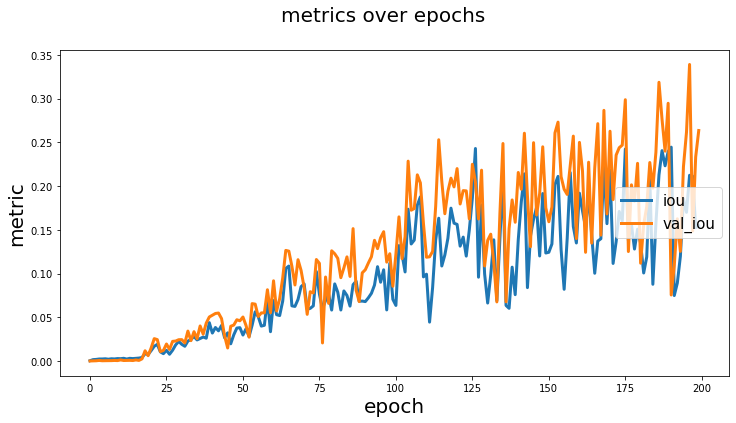

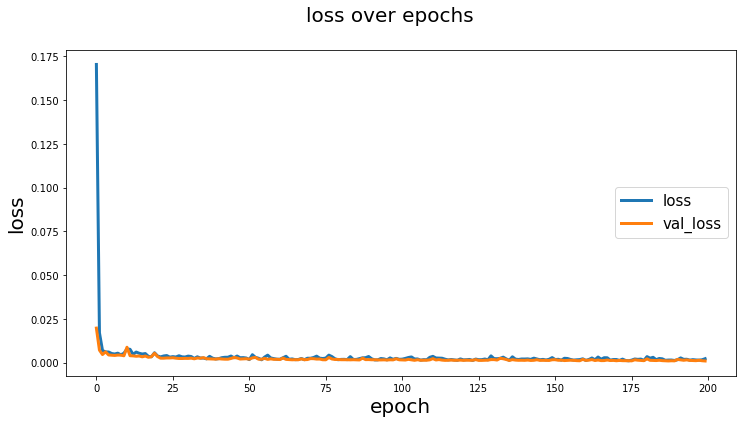

In [19]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [20]:
y_pred = model.predict(X_val)

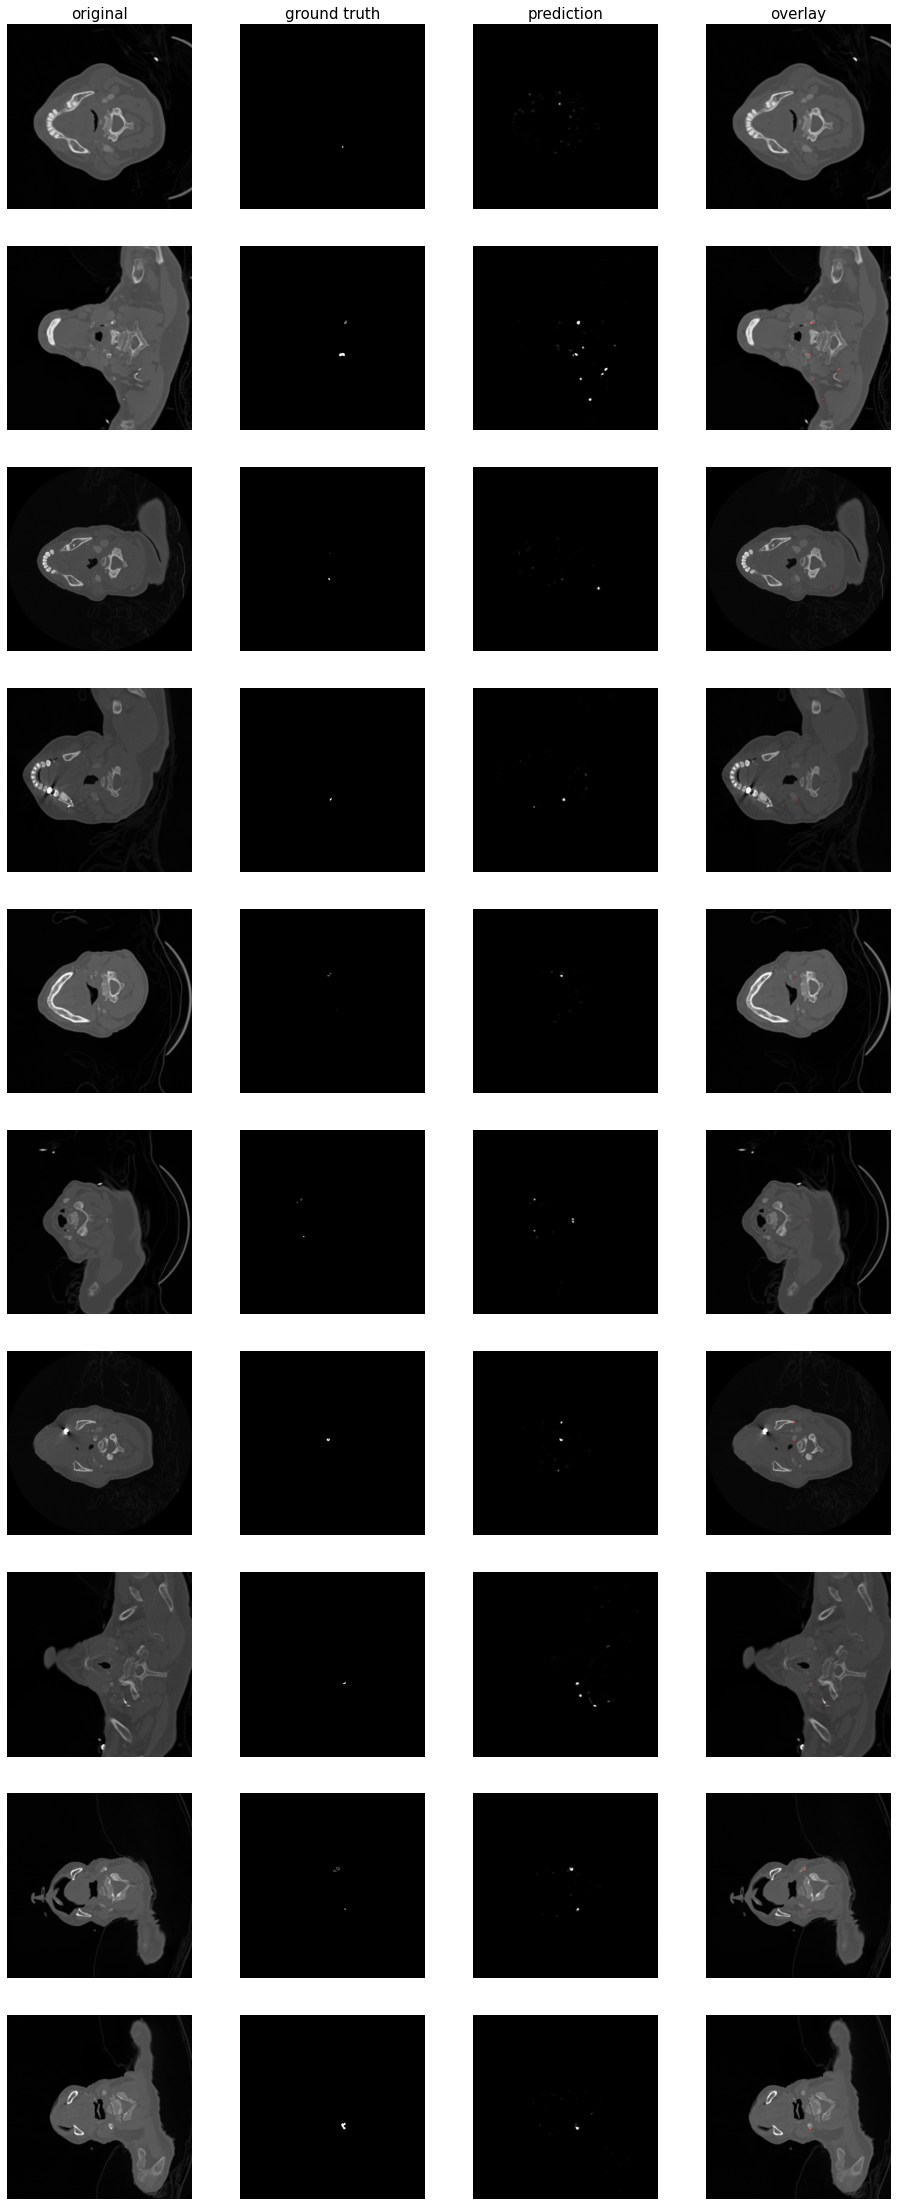

In [21]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [22]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

6/6 [==============================] - 0s 73ms/step - loss: 9.7813e-04 - iou: 0.2635 - iou_thresholded: 0.3583
